In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [2]:
### Config
project = "og-p_bursty"
use_cache = True
# use_cache = False
TOP_K_RUNS = 1000
STEP_INCR = 10000
ONLY_BEST = True


DIFF = "data.seq_config.p_bursty"
# XYS_TRAIN = "data.curriculum.points_train.end"
# XYS_VAL = "data.curriculum.points_val.end"
METRIC = "Accuracy"
# METRIC_TOK_VAL = "eval-eval.per_token_loss"
# METRIC_TOK_TEST = "eval-test.per_token_loss"
METRIC_VAL = "eval-eval.acc"
METRIC_TEST = "eval-test.acc"

# STEP='last'
STEP='best'

METRIC_MAX_MIN = "max"  # 'max' or 'min
# n_classes = [1.0, 0.9, 0.5, 0.0]
max_runs = 10000
states = ("finished",)
entity = "iceberg"
hist_cols = [
    METRIC_VAL,
    METRIC_TEST,
]
config_cols = ["model", DIFF]

pburst = 'data.seq_config.p_bursty'

In [3]:
def get_wandb_runs(entity, project):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    return runs

def extract_pow2_accs(x):
    pows = [int(2**i) - 1 for i in range(11)]
    extracted_accs = x[pows]
    return extracted_accs

def compute_avg_acc(x):
    return np.mean(x)

def build_fp(**kwargs):
    return "_".join([f"{k}={v}" for k, v in kwargs.items()]) + ".pkl"


def export_wandb_project(
    entity,
    project,
    config_cols,
    hist_cols,
    max_runs=None,
    states=("finished"),
    use_cache=False,
):
    fp = build_fp(entity=entity, project=project)
    if use_cache:
        try:
            return pd.read_pickle(fp)
        except FileNotFoundError:
            print(f"Cache file not found: {fp}. Exporting from wandb.")
            pass

    runs = get_wandb_runs(entity, project)
    run_data = []

    for run in tqdm(runs, desc="Exporting run data"):
        if (max_runs is not None) and (len(run_data) >= max_runs):
            break

        if run.state not in states:
            continue

        id = {"run_id": run.id, "sweep_id": str(run.sweep)}
        config = {k: run.config.get(k) for k in config_cols}
        config.update(id)
        hist = run.history(keys=hist_cols)

        # Combine all information and history data
        # combined_data = pd.concat([id, config, hist], axis=1)
        combined_data = hist.assign(**config)

        # Append the combined data to run_data list
        run_data.append(combined_data)

    # Combine all run data into a single DataFrame
    all_run_data = pd.concat(run_data, ignore_index=True)

    all_run_data.to_pickle(fp)
    return all_run_data


df = export_wandb_project(
    entity=entity,
    project=project,
    config_cols=config_cols,
    hist_cols=hist_cols,
    max_runs=max_runs,
    states=states,
    use_cache=use_cache,
)
print(df.shape)
df.head()

(34776, 7)


,_step,eval-eval.acc,eval-test.acc,model,data.seq_config.p_bursty,run_id,sweep_id
0,0,0.502,0.519,mamba,0.0,vj55jie5,<Sweep iceberg/og-p_bursty/ypmvp2ze (FINISHED)>
1,5000,0.481,0.499,mamba,0.0,vj55jie5,<Sweep iceberg/og-p_bursty/ypmvp2ze (FINISHED)>
2,10000,0.489,0.515,mamba,0.0,vj55jie5,<Sweep iceberg/og-p_bursty/ypmvp2ze (FINISHED)>
3,15000,0.515,0.498,mamba,0.0,vj55jie5,<Sweep iceberg/og-p_bursty/ypmvp2ze (FINISHED)>
4,20000,0.516,0.508,mamba,0.0,vj55jie5,<Sweep iceberg/og-p_bursty/ypmvp2ze (FINISHED)>


In [4]:
# ignore sweep_ids containing ypmvp2ze
df = df[~df.sweep_id.str.contains('ypmvp2ze')]
df.head()

,_step,eval-eval.acc,eval-test.acc,model,data.seq_config.p_bursty,run_id,sweep_id
756,0,0.512,0.491,mamba,0.0,hdrpel6o,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>
757,5000,0.499,0.494,mamba,0.0,hdrpel6o,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>
758,10000,0.488,0.502,mamba,0.0,hdrpel6o,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>
759,15000,0.501,0.525,mamba,0.0,hdrpel6o,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>
760,20000,0.496,0.514,mamba,0.0,hdrpel6o,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>


In [5]:
n_classes = df[pburst].unique()
n_classes

array([0. , 0.5, 0.9, 1. ])

In [6]:
df['model'].value_counts()

model
dynamicconv    3024
lightconv      3024
s4             3024
lstm           3024
gru            3024
rnn            3024
mamba          2268
llama2         2268
retnet         2268
gpt2           2268
hyena          2268
h3             2268
rwkv           2268
Name: count, dtype: int64

In [7]:
# count the number of unique run_ids for each model
unique_run_ids = df.groupby(['model']).agg({'run_id': 'nunique'}).reset_index()
# unique_run_ids['run_id'].apply(lambda x: len(x))
unique_run_ids

,model,run_id
0,dynamicconv,144
1,gpt2,108
2,gru,144
3,h3,108
4,hyena,108
5,lightconv,144
6,llama2,108
7,lstm,144
8,mamba,108
9,retnet,108


In [8]:
# for each run, look across its steps and find the best val acc
df['max_val_acc'] = df.groupby('run_id')['eval-eval.acc'].transform('max')
df[(df['model']=='rnn') & (df[pburst]==0.9)].head(25)

,_step,eval-eval.acc,eval-test.acc,model,data.seq_config.p_bursty,run_id,sweep_id,max_val_acc
6489,0,0.506,0.511,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6490,5000,0.502,0.486,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6491,10000,0.517,0.525,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6492,15000,0.518,0.498,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6493,20000,0.525,0.519,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6494,25000,0.483,0.504,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6495,30000,0.548,0.583,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6496,35000,0.563,0.540,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6497,40000,0.560,0.564,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600
6498,45000,0.504,0.522,rnn,0.9,2755cexa,<Sweep iceberg/og-p_bursty/dr0ymhb1 (FINISHED)>,0.600


In [9]:
df['avg_val_acc'] = df.groupby('run_id')['eval-eval.acc'].transform('mean')
df[(df['model']=='mamba') & (df[pburst]==0.9)].head()

,_step,eval-eval.acc,eval-test.acc,model,data.seq_config.p_bursty,run_id,sweep_id,max_val_acc,avg_val_acc
1890,0,0.512,0.491,mamba,0.9,dgrzacit,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.535,0.507762
1891,5000,0.490,0.491,mamba,0.9,dgrzacit,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.535,0.507762
1892,10000,0.514,0.517,mamba,0.9,dgrzacit,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.535,0.507762
1893,15000,0.511,0.522,mamba,0.9,dgrzacit,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.535,0.507762
1894,20000,0.489,0.504,mamba,0.9,dgrzacit,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.535,0.507762


In [10]:
def get_best_run_id(df, best_run_metric):
    df = df.copy()
    # collapse run_id
    df = df.groupby(['model', 'data.seq_config.p_bursty', 'run_id']).agg({best_run_metric: 'max'})
    # get run_id with the max best_run_metric
    idx = df.groupby(['model', 'data.seq_config.p_bursty'])[best_run_metric].transform('max') == df[best_run_metric]
    df = df[idx]
    # tie break run_ids by taking the first one, don't lose run_id
    df = df.reset_index().groupby(['model', 'data.seq_config.p_bursty']).first()
    # flatten
    df = df.reset_index()
    return df
# get the run ids of the runs with the best val acc for a specific step
# best_run_metric = 'avg_val_acc'
best_run_metric = 'max_val_acc'
best_run_ids = get_best_run_id(df, best_run_metric)
best_run_ids

,model,data.seq_config.p_bursty,run_id,max_val_acc
0,dynamicconv,0.0,lssju9n3,0.550
1,dynamicconv,0.5,ajolfddq,0.552
2,dynamicconv,0.9,rlj1cu17,0.561
3,dynamicconv,1.0,tjuvdq2j,0.664
4,gpt2,0.0,ppnz10c4,0.542
5,gpt2,0.5,tuf3z5zs,0.648
6,gpt2,0.9,2vuf1d5z,0.957
7,gpt2,1.0,odiva41w,0.964
8,gru,0.0,rw6tyuah,0.558
9,gru,0.5,h02l1z40,0.689


In [11]:
if ONLY_BEST:
    df = df[df.run_id.isin(best_run_ids.run_id)]
else:
    # for each model and p_bursty, average across all runs
    df = df.groupby(['model', 'data.seq_config.p_bursty', '_step']).agg({'eval-eval.acc': 'mean', 'eval-test.acc': 'mean'}).reset_index()
print(df.shape)
# show only model==llama2 and p_bursty==0.9
df[(df['model']=='rnn') & (df[pburst]==0.9)].head(23)

(1092, 9)


,_step,eval-eval.acc,eval-test.acc,model,data.seq_config.p_bursty,run_id,sweep_id,max_val_acc,avg_val_acc
25641,0,0.536,0.476,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25642,5000,0.516,0.499,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25643,10000,0.516,0.477,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25644,15000,0.489,0.496,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25645,20000,0.514,0.514,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25646,25000,0.485,0.502,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25647,30000,0.636,0.677,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25648,35000,0.711,0.683,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25649,40000,0.661,0.668,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095
25650,45000,0.625,0.651,rnn,0.9,5mu43c1b,<Sweep iceberg/og-p_bursty/rfp1dnz1 (FINISHED)>,0.711,0.554095


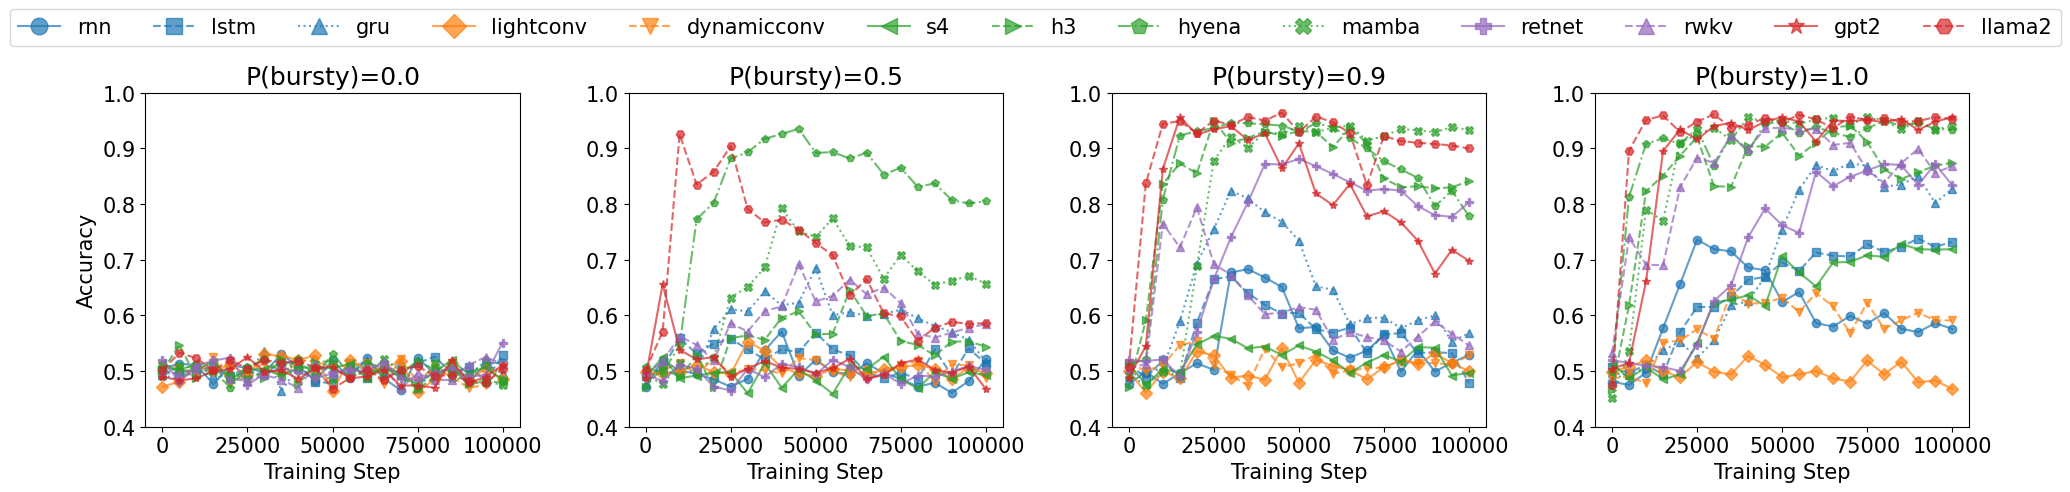

In [12]:
style_map = {
    'rnn': {'color': '#1f77b4', 'linestyle': 'solid', 'marker': 'o'},  # Solid line, circle marker
    'lstm': {'color': '#1f77b4', 'linestyle': '--', 'marker': 's'},  # Dashed line, square marker
    'gru': {'color': '#1f77b4', 'linestyle': ':', 'marker': '^'},  # Dash-dot line, triangle up marker

    'lightconv': {'color': '#ff7f0e', 'linestyle': 'solid', 'marker': 'D'},  # Solid line, diamond marker
    'dynamicconv': {'color': '#ff7f0e', 'linestyle': '--', 'marker': 'v'},  # Dashed line, triangle down marker

    's4': {'color': '#2ca02c', 'linestyle': 'solid', 'marker': '<'},  # Solid line, triangle left marker
    'h3': {'color': '#2ca02c', 'linestyle': '--', 'marker': '>'},  # Dashed line, triangle right marker
    'hyena': {'color': '#2ca02c', 'linestyle': '-.', 'marker': 'p'},  # Dash-dot line, pentagon marker
    'mamba': {'color': '#2ca02c', 'linestyle': ':', 'marker': 'X'},  # Dotted line, x marker

    'llama2': {'color': '#d62728', 'linestyle': '--', 'marker': 'H'},  # Dashed line, hexagon marker
    'gpt2': {'color': '#d62728', 'linestyle': 'solid', 'marker': '*'},  # Dash-dot line, star marker

    'retnet': {'color': '#9467bd', 'linestyle': 'solid', 'marker': 'P'},  # Solid line, plus (filled) marker
    'rwkv': {'color': '#9467bd', 'linestyle': '--', 'marker': '^'},  # Dashed line, vertical line marker
}

legend_order = ['rnn', 'lstm', 'gru', 'lightconv', 'dynamicconv', 's4', 'h3', 'hyena', 'mamba', 'retnet', 'rwkv', 'gpt2', 'llama2']

import matplotlib.pyplot as plt

def plot_all_classes(df, n_classes_list, style_map, legend_order):
    # Create a figure with subplots laid out horizontally
    fig, axes = plt.subplots(1, len(n_classes_list), figsize=(20, 5)) # 'figsize' might need adjustment based on your screen/desired size

    # Iterate over each class and its corresponding subplot
    for idx, n_classes in enumerate(n_classes_list):
        ax = axes[idx] # Get the current axes
        df_filtered = df[df[pburst] == n_classes]

        handles = []  # List to hold the handles for the legend entries
        labels = []  # List to hold the labels for the legend entries

        for model in legend_order:  # Iterate over the models in the specified legend order
            if model in df_filtered['model'].unique():  # Plot if the model is in the dataframe
                df_model = df_filtered[df_filtered['model'] == model]
                style_args = style_map.get(model, {}) 
                line, = ax.plot(
                    df_model["_step"],
                    df_model["eval-test.acc"],
                    label=model,
                    alpha=0.7,
                    **style_args,
                )
                handles.append(line)  # Append the handle for the line
                labels.append(model)  # Append the label for the model

        # for h in handles:
        #     h.set_markersize(10)
        ax.set_xlabel("Training Step")
        if idx == 0:
            ax.set_ylabel("Accuracy")
        ax.set_ylim(0.4, 1)  # set y lim
        ax.set_title(f"P(bursty)={n_classes}")

    # Place a single legend on the figure
    fig.legend(handles, labels, loc='upper center', ncol=len(legend_order), bbox_to_anchor=(0.5, 1.05), markerscale=2)
    plt.tight_layout(pad=2.0) # Adjust the padding between and around subplots

    # Show the complete figure with all subplots
    plt.show()

plt.rcParams.update({'font.size': 15})
# Assuming 'n_classes' is a list of class counts and 'df' is your dataframe, and 'pburst' is a valid column in 'df'
plot_all_classes(df, n_classes, style_map, legend_order)  # Replace [1, 2, 3, 4] with your actual n_classes_list


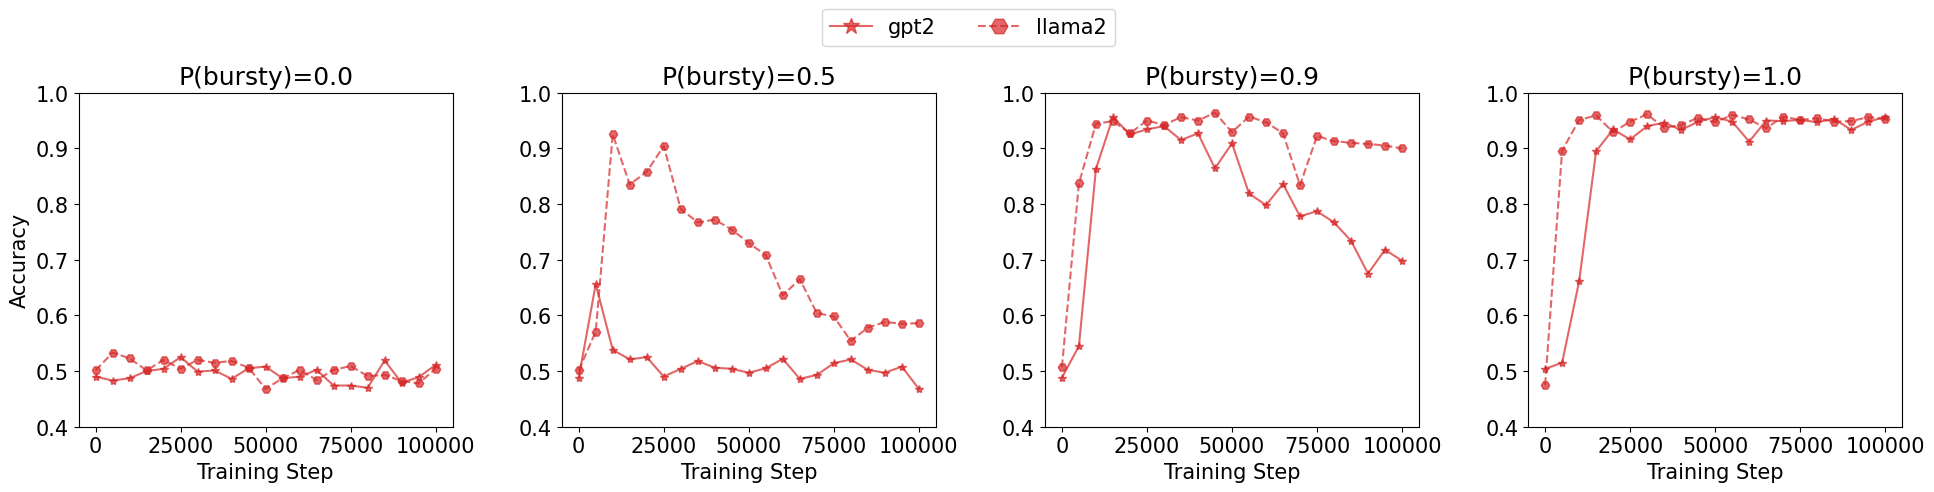

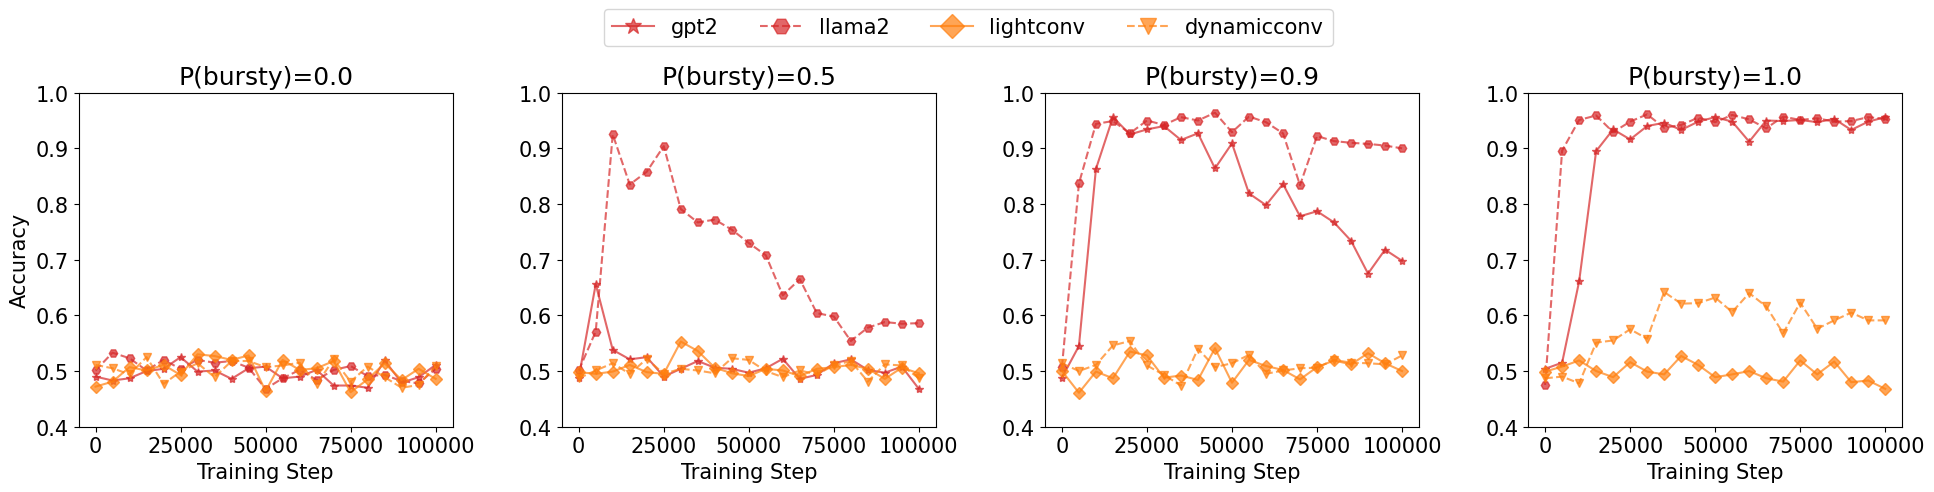

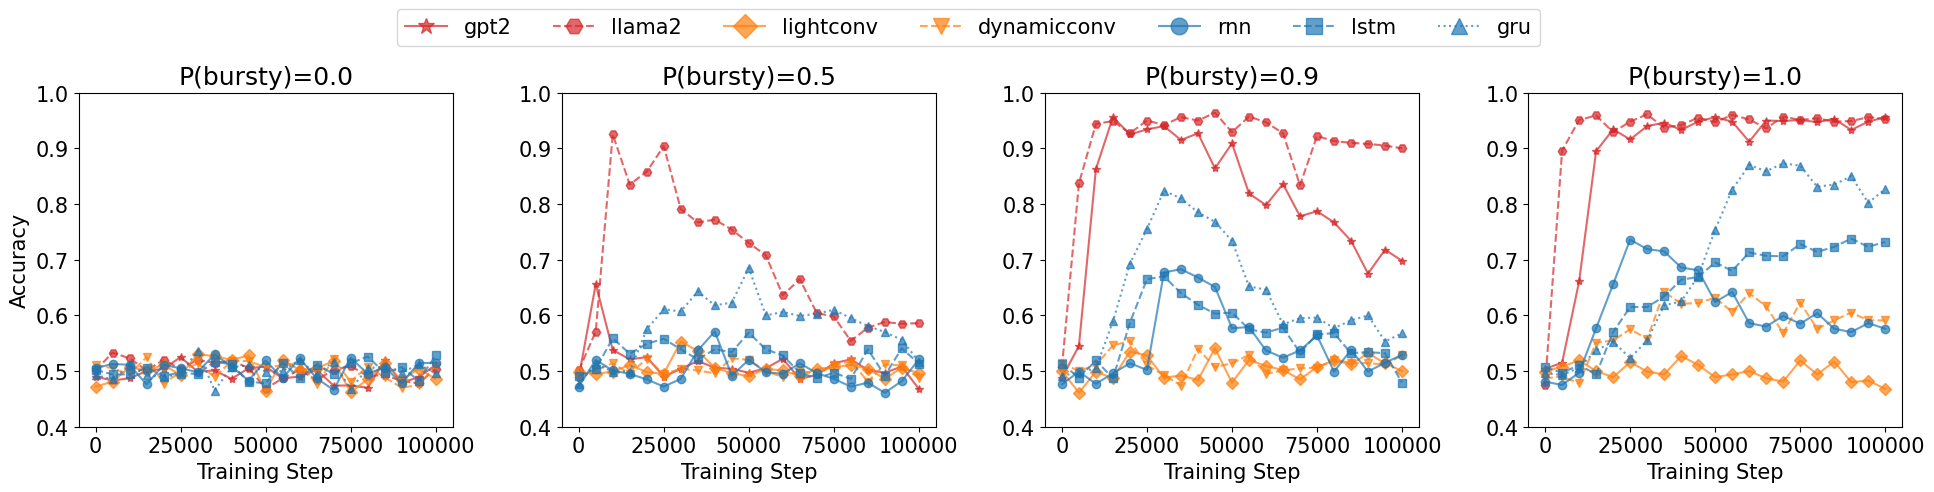

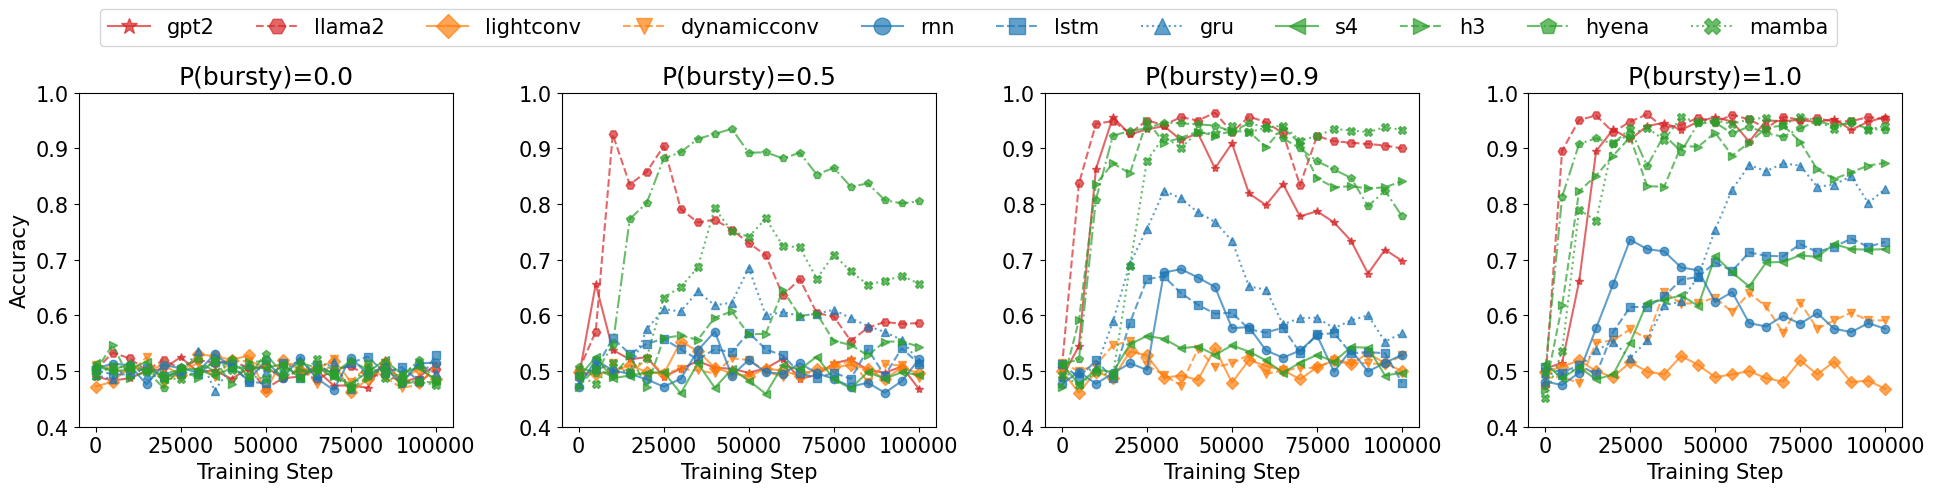

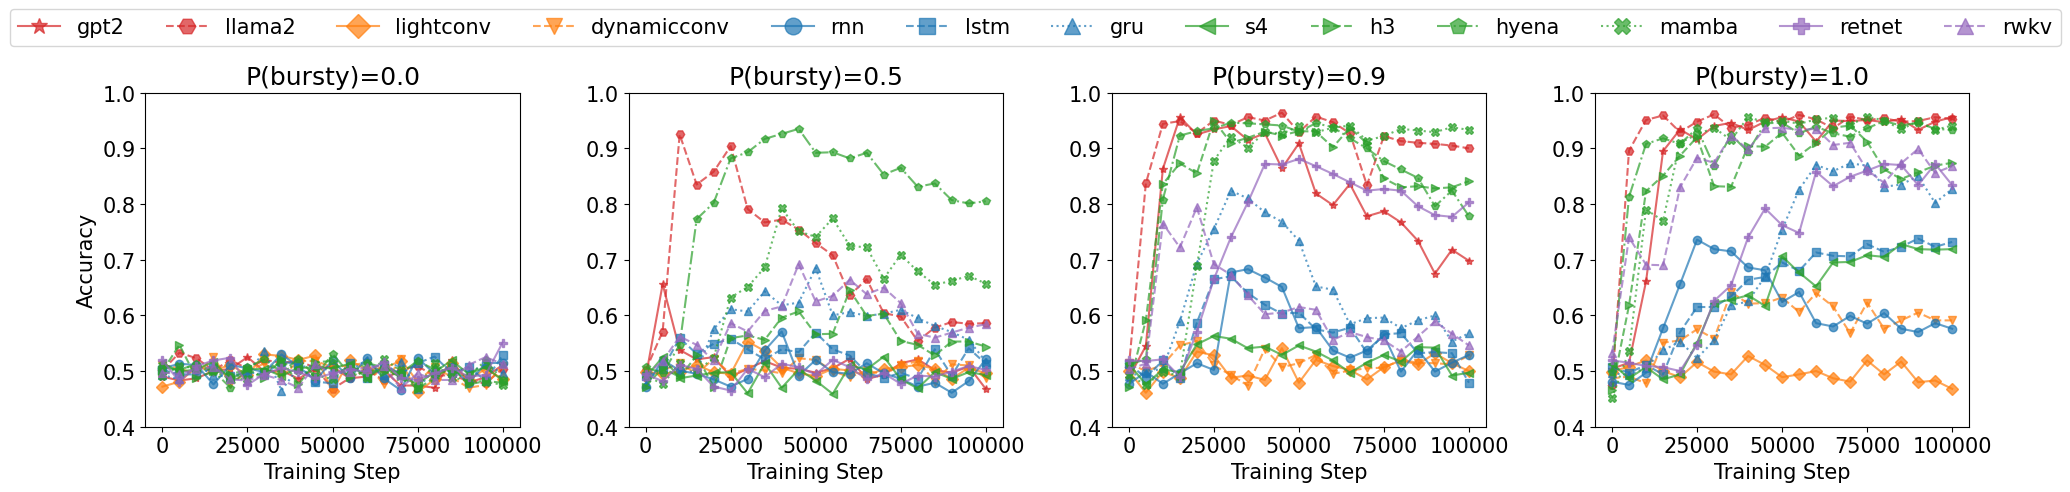

In [13]:
transformers = ['gpt2', 'llama2']
rnns = ['rnn', 'lstm', 'gru']
cnns = ['lightconv', 'dynamicconv']
ssms = ['s4', 'h3', 'hyena', 'mamba']
attalts = ['retnet', 'rwkv']
legend_order = []
for family in [transformers, cnns, rnns, ssms, attalts]:
    legend_order += family
    plt.rcParams.update({'font.size': 15})
    # Assuming 'n_classes' is a list of class counts and 'df' is your dataframe, and 'pburst' is a valid column in 'df'
    plot_all_classes(df, n_classes, style_map, legend_order)  # Replace [1, 2, 3, 4] with your actual n_classes_list

In [14]:
df.head()

,_step,eval-eval.acc,eval-test.acc,model,data.seq_config.p_bursty,run_id,sweep_id,max_val_acc,avg_val_acc
1260,0,0.526,0.491,mamba,0.0,7q5z6ejp,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.554,0.500905
1261,5000,0.554,0.509,mamba,0.0,7q5z6ejp,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.554,0.500905
1262,10000,0.484,0.505,mamba,0.0,7q5z6ejp,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.554,0.500905
1263,15000,0.508,0.500,mamba,0.0,7q5z6ejp,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.554,0.500905
1264,20000,0.502,0.486,mamba,0.0,7q5z6ejp,<Sweep iceberg/og-p_bursty/sife57eq (FINISHED)>,0.554,0.500905


In [15]:
import pandas as pd

def create_table(df, n_class, step_increment=STEP_INCR):
    # Filter the dataframe for the current class
    df_class = df[df[pburst] == n_class]

    # Create a pivot table with model names as rows and specific training steps as columns
    # Ensure the '_step' is within the range you are interested in by filtering the dataframe
    # df_class = df_class[df_class['_step'].max() - df_class['_step'] < step_increment]

    # Create a table with training steps as columns
    # max_step = int(df_class['_step'].max())  # Find the maximum step for the current class
    # Create a list of steps in increments of 'step_increment' from 0 to 'max_step'
    step_cols = list(range(0, 100000 + step_increment, step_increment))
    # Select rows where '_step' matches our step increments and drop duplicates keeping the highest 'eval-test.acc'
    df_pivot = (df_class[df_class['_step'].isin(step_cols)])
                # .sort_values('eval-test.acc', ascending=False)
                # .drop_duplicates(subset=['model', '_step']))

    # Pivot the processed DataFrame
    pivot_table = df_pivot.pivot(index='model', columns='_step', values='eval-test.acc')

    # Reorder the pivot table to include all steps, even those without records, using reindex
    pivot_table = pivot_table.reindex(columns=step_cols, fill_value=None)  # Fill missing steps with NaN

    # Print the pivot table
    print(f"Table for pburst={n_class}")
    display(pivot_table)  # Use display for a nicer table format in Jupyter Notebooks

for n in n_classes:
    create_table(df, n)


Table for pburst=0.0


_step,0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000
model,,,,,,,,,,,
dynamicconv,0.511,0.494,0.477,0.514,0.518,0.507,0.515,0.521,0.508,0.470,0.509
gpt2,0.490,0.487,0.504,0.499,0.486,0.508,0.490,0.474,0.470,0.479,0.511
gru,0.493,0.510,0.489,0.536,0.507,0.499,0.520,0.517,0.505,0.497,0.496
h3,0.500,0.487,0.494,0.488,0.476,0.518,0.502,0.492,0.488,0.476,0.479
hyena,0.507,0.513,0.470,0.521,0.522,0.531,0.515,0.496,0.503,0.490,0.484
lightconv,0.472,0.507,0.511,0.530,0.520,0.464,0.502,0.518,0.485,0.484,0.486
llama2,0.501,0.523,0.520,0.520,0.518,0.468,0.502,0.502,0.491,0.482,0.504
lstm,0.502,0.494,0.491,0.494,0.512,0.478,0.488,0.495,0.526,0.507,0.528
mamba,0.491,0.505,0.486,0.499,0.501,0.486,0.487,0.501,0.514,0.483,0.475


Table for pburst=0.5


_step,0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000
model,,,,,,,,,,,
dynamicconv,0.487,0.514,0.522,0.504,0.496,0.520,0.489,0.494,0.518,0.512,0.487
gpt2,0.488,0.538,0.525,0.504,0.506,0.497,0.522,0.493,0.521,0.497,0.468
gru,0.477,0.499,0.575,0.607,0.618,0.685,0.606,0.603,0.595,0.570,0.517
h3,0.472,0.489,0.471,0.564,0.596,0.566,0.645,0.603,0.547,0.553,0.544
hyena,0.507,0.547,0.802,0.893,0.926,0.892,0.882,0.853,0.831,0.807,0.805
lightconv,0.498,0.499,0.498,0.553,0.506,0.491,0.501,0.504,0.511,0.486,0.496
llama2,0.501,0.925,0.858,0.791,0.772,0.730,0.636,0.604,0.554,0.588,0.586
lstm,0.491,0.559,0.549,0.539,0.539,0.569,0.528,0.487,0.486,0.492,0.513
mamba,0.493,0.514,0.524,0.651,0.792,0.741,0.725,0.666,0.679,0.662,0.657


Table for pburst=0.9


_step,0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000
model,,,,,,,,,,,
dynamicconv,0.514,0.511,0.554,0.493,0.540,0.514,0.495,0.505,0.520,0.514,0.528
gpt2,0.488,0.863,0.925,0.940,0.927,0.909,0.798,0.778,0.767,0.675,0.698
gru,0.492,0.505,0.693,0.824,0.785,0.734,0.646,0.595,0.577,0.600,0.568
h3,0.472,0.836,0.855,0.910,0.930,0.931,0.902,0.909,0.830,0.828,0.841
hyena,0.512,0.808,0.931,0.946,0.943,0.930,0.938,0.900,0.862,0.796,0.778
lightconv,0.500,0.499,0.535,0.488,0.484,0.479,0.509,0.485,0.519,0.532,0.500
llama2,0.507,0.944,0.927,0.942,0.950,0.929,0.947,0.834,0.913,0.908,0.900
lstm,0.513,0.519,0.587,0.670,0.619,0.605,0.569,0.533,0.568,0.534,0.479
mamba,0.493,0.498,0.688,0.921,0.929,0.940,0.937,0.914,0.935,0.929,0.933


Table for pburst=1.0


_step,0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000
model,,,,,,,,,,,
dynamicconv,0.487,0.478,0.555,0.558,0.621,0.632,0.640,0.568,0.576,0.605,0.591
gpt2,0.504,0.661,0.934,0.940,0.933,0.956,0.912,0.949,0.947,0.933,0.956
gru,0.496,0.506,0.553,0.555,0.625,0.754,0.870,0.873,0.831,0.850,0.827
h3,0.466,0.823,0.887,0.832,0.904,0.928,0.910,0.941,0.862,0.857,0.874
hyena,0.498,0.908,0.908,0.868,0.894,0.946,0.939,0.921,0.949,0.946,0.933
lightconv,0.499,0.519,0.489,0.499,0.527,0.489,0.500,0.481,0.494,0.480,0.468
llama2,0.475,0.951,0.929,0.961,0.942,0.947,0.952,0.957,0.954,0.949,0.953
lstm,0.507,0.511,0.570,0.615,0.664,0.695,0.713,0.706,0.714,0.738,0.732
mamba,0.451,0.790,0.910,0.937,0.956,0.950,0.952,0.942,0.950,0.949,0.941


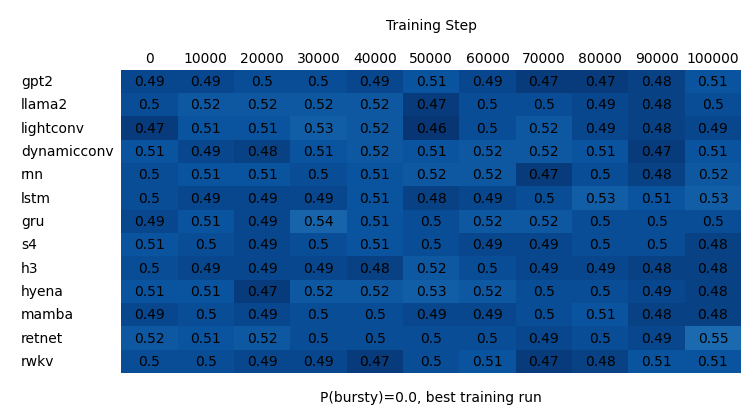

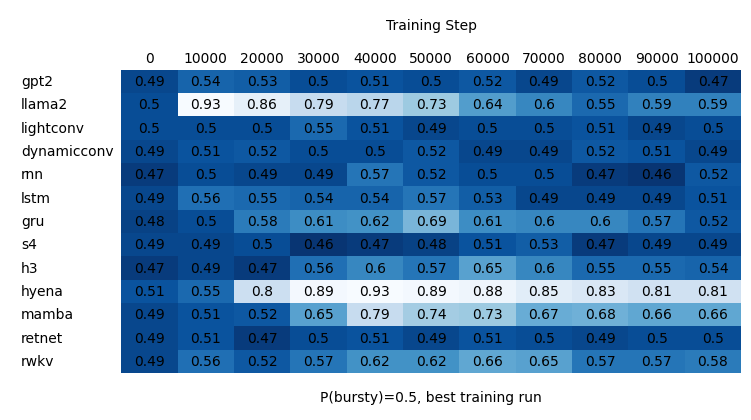

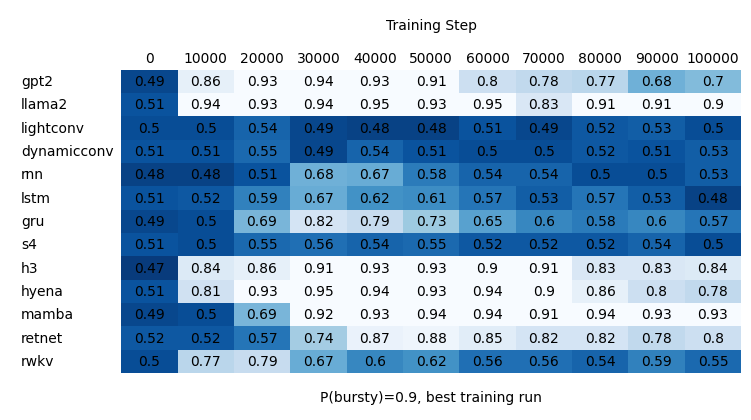

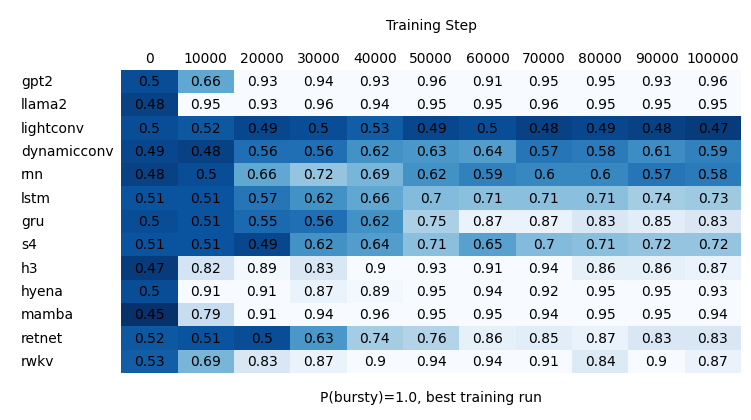

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import Normalize

def create_table(df, n_class, step_increment=STEP_INCR):
    df = df.copy()
    # Filter the dataframe for the current class
    df_class = df[df[pburst] == n_class]

    # Generate step columns and find unique models
    step_cols = list(range(0, 100000 + step_increment, step_increment))
    unique_models = df_class['model'].unique()
    unique_models = legend_order

    # Create a DataFrame to store rounded accuracy values
    data_for_table = pd.DataFrame(index=unique_models, columns=step_cols, dtype=float) # ensure the dtype is float

    # Populate and round the data within the loop
    for model in unique_models:
        model_data = df_class[df_class['model'] == model]
        for step in step_cols:
            # Find the row with the current step (if exists)
            row = model_data[model_data['_step'] == step]
            if not row.empty:
                # If there's a row for the current step, take the first accuracy value
                acc_value = row['eval-test.acc'].iloc[0]
                # Assign it to the table after rounding
                data_for_table.at[model, step] = round(acc_value, 2) # round the value before assignment

    # Normalize the data for the heatmap
    norm = Normalize(vmin=0.45, vmax=0.9)

    # Create the heatmap table
    fig, ax = plt.subplots(figsize=(8, 0.4 * len(unique_models)))  # Adjust figure size as needed
    ax.axis('off')

    # Apply normalization and color map to the rounded data
    norm_data = norm(data_for_table.values)  # Normalize only the numeric data
    table_colors = plt.cm.Blues_r(norm_data)  # Get the colors for the table based on normalized values

    # Create the table using the normalized color map
    table = ax.table(
        cellText=data_for_table.map(lambda x: '' if pd.isna(x) else x).values,  # Convert NaN to empty string for text display
        cellColours=table_colors,  # Color cells based on the normalized data
        rowLabels=data_for_table.index,
        colLabels=data_for_table.columns,
        loc='center',
        cellLoc='center'
    )

    for key, cell in table.get_celld().items():
        cell.set_edgecolor('none')

    # Adjust table font size and scaling
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.4)  # Adjust scaling to fit

    # make clear that columns are query indices
    ax.text(0.5, 0.95, f"Training Step", transform=ax.transAxes, ha="center", fontsize=10)

    runs_title = "best training run" if ONLY_BEST else "average over all training runs"
    ax.text(0.5, 0.02, f"P(bursty)={n_class}, {runs_title}", transform=ax.transAxes, ha="center", fontsize=10)


    # Display the figure
    plt.show()




for n in n_classes:
    create_table(df, n)
